<a href="https://colab.research.google.com/github/ShelinVankawala/Reddit-Flair-Detection/blob/main/RedditLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Import required libraries

import praw                       # To crawl Reddit and collect data
import pandas as pd               # To work with csv files
import matplotlib.pyplot as plt   # To plot graphs
import requests                   # To send POST requests
import time                       # To track time stamp of submissions
import pickle                     # To save and load the data we collect

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Reddit/reddit-india-data.csv', parse_dates=['timestamp'])

In [ ]:
flairs = ["Sports", "Politics", "AskIndia", "Business/Finance", "Food", "Science/Technology", "Non-Political", "Photography", "Policy/Economy", "Scheduled", "[R]eddiquette", "Food", "Coronavirus", "Demonetization", "CAA-NRC"]

filtered_data = pd.DataFrame(data, columns=['id', 'title', 'score', 'flair'])

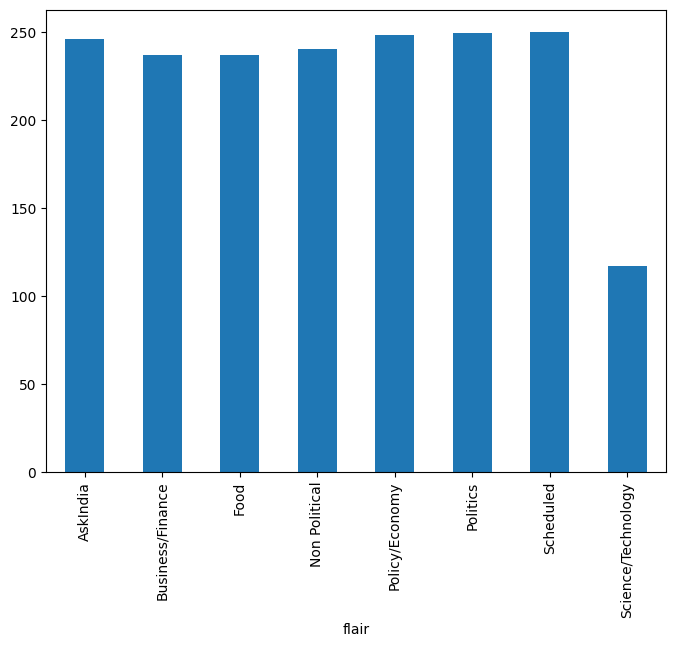

In [ ]:
fig = plt.figure(figsize=(8,6))
filtered_data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [ ]:
filtered_data.to_csv('balanced_data.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, Layer, Dense, Input, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/balanced_data.csv')

# Tokenize the posts, ie assign keys to each of the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.title)
X = tokenizer.texts_to_sequences(df.title)
df['tokenized'] = X
X = list(sequence.pad_sequences(df.tokenized, maxlen=50))
word_index = tokenizer.word_index

In [ ]:
flairs = df.groupby('flair').size().index.tolist()
flair_to_key = {}
key_to_flair = {}
for key, flair in enumerate(flairs):
  flair_to_key[flair] = key
  key_to_flair[key] = flair

df['key'] = df['flair'].apply(lambda x: flair_to_key[x])

In [ ]:
X = np.array(X)
Y = to_categorical(list(df.key))
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, stratify=Y)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1550, 50) (274, 50) (1550, 8) (274, 8)


In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Preparing the embedding layer using Stanford's 100 dimensional GloVe word vectors: https://nlp.stanford.edu/projects/glove/
# First we create a mapping from the words to their vector representation

mapping = {}
f = open('/content/drive/MyDrive/Reddit/glove.6B.100d.txt')
for embedding in f:
    embedding = embedding.split()
    word = embedding[0]
    vector = embedding[1:]
    vector = np.asarray(vector, dtype='float32')
    mapping[word] = vector
f.close()

In [ ]:
embedding_weights = np.zeros((len(word_index)+1, 100))
for word, idx in word_index.items():
    vector = mapping.get(word)
    if vector is not None:
        embedding_weights[idx] = vector

embedding_layer = Embedding(len(word_index)+1, 100, embeddings_initializer=Constant(embedding_weights), input_length=50, trainable=False)


In [ ]:
inputs = Input(shape=(50,), dtype='int32')
x = embedding_layer(inputs)
x = Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Attention(50)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
outputs = Dense(8, activation='softmax')(x)

checkpoint = ModelCheckpoint('best_weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks=[checkpoint])

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7389 - acc: 0.7200
Epoch 1: val_acc did not improve from 0.56204
25/25 [==============================] - 94s 4s/step - loss: 0.7389 - acc: 0.7200 - val_loss: 1.2115 - val_acc: 0.5438
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7112 - acc: 0.7277
Epoch 2: val_acc did not improve from 0.56204
25/25 [==============================] - 99s 4s/step - loss: 0.7112 - acc: 0.7277 - val_loss: 1.2368 - val_acc: 0.5365
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6723 - acc: 0.7400
Epoch 3: val_acc did not improve from 0.56204
25/25 [==============================] - 98s 4s/step - loss: 0.6723 - acc: 0.7400 - val_loss: 1.2949 - val_acc: 0.5146
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6306 - acc: 0.7535
Epoch 4: val_acc improved from 0.56204 to 0.56934, saving model to best_weights.hdf5
25/25 [==============================] - 98s 4s/step - loss: 0.6

In [ ]:
import pickle
pickle_out = open("tokenizer.pickle", "wb")
pickle.dump(tokenizer, pickle_out)
pickle_out.close()

In [ ]:
model.load_weights("best_weights.hdf5")

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

preds = model.predict(x_val)
y = np.asarray([np.argmax(line) for line in y_val])
preds = np.asarray([np.argmax(line) for line in preds])

print("Accuracy = {}".format(accuracy_score(y, preds)))
print("F1 score = {}".format(f1_score(y, preds, average='macro')))
print("Precision = {}".format(precision_score(y, preds, average='macro')))
print("Recall = {}".format(recall_score(y, preds, average='macro')))

9/9 [==============================] - 6s 634ms/step
Accuracy = 0.5766423357664233
F1 score = 0.5557675612227422
Precision = 0.5544982452315278
Recall = 0.5673798798798798
